# Ancestral sequence reconstruction for representative sequences of PF00144
This notebook reconstructs the ancestor at the root of the subtree induced by the representative sequences from the Detlefsen code for the PF00144 family based on the trained VAE model

## Set-up

In [1]:
import os
from ete3 import Tree
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import logomaker # for plotting sequences of distributions over amino acids 
from Bio import SeqIO # for reading FASTA files
import pandas as pd
from utilities.tree import filter_msa_by_tree, run_iqtree, run_fitch
from utilities.seq import invert_dict, aa_to_int_from_path
from utilities.vae import load_model, load_data
from utilities.utils import get_directory, parse_model_name
from scripts.decode_recon_embeds import get_recon_ancseqs, get_profile_leaves, get_iqtree_ancseqs

In [2]:
MSA_id = "PF00144_og"
data_path = f"msas/real/processed/{MSA_id}"
tree_path = f"trees/inferred_real_trees/PF00144_subtree-mid.treefile"
model_hd_name = "ding_layers1000_ld20_wd0.005_epoch500_2025-08-14.pt"
model_ld_name = "ding_layers1000_ld2_wd0.0_epoch500_2025-08-12.pt"

In [3]:
AA2IDX = aa_to_int_from_path(data_path)
IDX2AA = invert_dict(AA2IDX, unknown_symbol="-") 
print(AA2IDX)
print(IDX2AA)
nc = len(IDX2AA) # 20 or 21, depending on whether there are gaps in the MSA


{'-': 0, '.': 0, 'X': 0, 'B': 0, 'Z': 0, 'J': 0, 'R': 1, 'H': 2, 'K': 3, 'D': 4, 'E': 5, 'S': 6, 'T': 7, 'N': 8, 'Q': 9, 'C': 10, 'G': 11, 'P': 12, 'A': 13, 'V': 14, 'I': 15, 'L': 16, 'M': 17, 'F': 18, 'Y': 19, 'W': 20}
{0: '-', 1: 'R', 2: 'H', 3: 'K', 4: 'D', 5: 'E', 6: 'S', 7: 'T', 8: 'N', 9: 'Q', 10: 'C', 11: 'G', 12: 'P', 13: 'A', 14: 'V', 15: 'I', 16: 'L', 17: 'M', 18: 'F', 19: 'Y', 20: 'W'}


Some functions:

In [ ]:
def calc_marginal_freq(seqs_int, nc=21, wts=None):
    if wts is None:
        wts = np.ones(seqs_int.shape[0])
    nl = seqs_int.shape[1]
    freqs = np.zeros((nl, nc))
    for idx_seq, seq in enumerate(seqs_int):
        for idx_pos, aa in enumerate(seq):
            freqs[idx_pos, aa] += wts[idx_seq]
    return freqs / wts.sum()


def plot_logo(ary_of_pos_dists, 
              interval = (0, 10), 
              idx2aa=IDX2AA, 
              type="probability",
              ax=None):
    """
    Plot a logo of the first n and last n positions of the distribution
    
    Args: 
        ary_of_pos_dists: 2D NumPy array of distributions over amino acids (shape is (nl, nc) and rows should sum to 1)
        interval: A tuple specifying the start (inclusive) and end (exclusive) positions to plot.
            Defaults to (90, 100).
        type:  "probability" (default) or "information" 
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    # remove the column corresponding to the unknown symbol and renormalize
    if ary_of_pos_dists.shape[1] == 21:
        ary_of_pos_dists = ary_of_pos_dists[:, 1:]
        ary_of_pos_dists /= ary_of_pos_dists.sum(axis=1, keepdims=True)
    
    # Subset the rows to only look at postitions in interval if necessary
    if ary_of_pos_dists.shape[0] > interval[1] - interval[0]:
        ary_of_pos_dists = ary_of_pos_dists[interval[0]:interval[1]]

    # Convert p_ave to a pandas DataFrame
    df_of_pos_dists = pd.DataFrame(ary_of_pos_dists, columns=[idx2aa[i] for i in range(1, 21)])
    
    # Convert to values that you want to plot (probability or information)
    if type != "probability":
        df_of_pos_dists = logomaker.transform_matrix(df_of_pos_dists, from_type="probability", to_type=type)

    # Create the sequence logo plot
    logo = logomaker.Logo(df_of_pos_dists, shade_below=.5, fade_below=.5, font_name='Arial', ax=ax)
    
    # Aesthetics
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    #logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    ax.set_xticks(range(len(df_of_pos_dists)))
    ax.set_xticklabels(range(interval[0], interval[1]), rotation=90)
    ax.set_xlabel('Position in Sequence')
    if type == "probability":
        ax.set_ylim(0, 1.0)
    ax.set_ylabel(type.capitalize())

    return ax
    


## Load data

In [5]:
data, nl, nc = load_data(data_path, weigh_seqs=False, one_hot=False)
msa_int, ids = data.msa, data.seq_keys

## Load embeddings

In [6]:
embeds_dir = get_directory(data_path, "embeddings", data_subfolder=True)

embeds_ld_path = os.path.join(embeds_dir, model_ld_name.replace(".pt", "_rep-anc-embeddings.csv"))
embeds_ld = pd.read_csv(embeds_ld_path, index_col="id")
embeds_ld = embeds_ld.loc[:, embeds_ld.columns.str.startswith("dim")]
display(embeds_ld.loc[["Root"],:])


embeds_hd_path = os.path.join(embeds_dir, model_hd_name.replace(".pt", "_rep-anc-embeddings.csv"))
embeds_hd = pd.read_csv(embeds_hd_path, index_col="id")
embeds_hd = embeds_hd.loc[:, embeds_hd.columns.str.startswith("dim")]
display(embeds_hd.loc[["Root"],:])

n_anc = embeds_ld.shape[0]


,dim0,dim1
id,,
Root,-0.973752,0.363292


,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19
id,,,,,,,,,,,,,,,,,,,,
Root,-0.169221,0.136645,-0.116703,0.233135,-0.72326,0.008936,0.220197,-0.58258,-0.054459,0.314153,0.113257,0.238354,0.239726,-0.020108,0.906251,-0.003038,0.142826,-0.267359,-0.117762,0.260302


## Load model

In [7]:
# 2 dim latent space model
model_dir = get_directory(data_path, "saved_models")
model_path_ld = os.path.join(model_dir, model_ld_name)
is_trans, ld, layers, dim_aa_embed, one_hot = parse_model_name(model_path_ld)
ding_model = model_ld_name.startswith("ding")
model_ld = load_model(model_path_ld, nl=nl, nc=nc, ding_model=ding_model,
                   num_hidden_units=layers, nlatent=ld, 
                   one_hot=one_hot, dim_aa_embed=dim_aa_embed, trans=is_trans)
model_ld.eval()
# 20 dim latent space model
model_path_hd = os.path.join(model_dir, model_hd_name)
is_trans, ld, layers, dim_aa_embed, one_hot = parse_model_name(model_path_hd)
ding_model = model_hd_name.startswith("ding")
model_hd = load_model(model_path_hd, nl=nl, nc=nc, ding_model=ding_model,
                   num_hidden_units=layers, nlatent=ld, 
                   one_hot=one_hot, dim_aa_embed=dim_aa_embed, trans=is_trans)
model_hd.eval()

VAE(
  (encoder_linears): ModuleList(
    (0): Linear(in_features=4809, out_features=1000, bias=True)
  )
  (encoder_mu): Linear(in_features=1000, out_features=20, bias=True)
  (encoder_logsigma): Linear(in_features=1000, out_features=20, bias=True)
  (decoder_linears): ModuleList(
    (0): Linear(in_features=20, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=4809, bias=True)
  )
)

## Ancestral reconstruction 

In [8]:
anc_id = embeds_ld.index 
assert 0 == anc_id.get_loc("Root") 
assert (anc_id == embeds_hd.index).all()

Profile of leaves

In [9]:
consensus_probs = get_profile_leaves(data_path, n_anc, return_probs=True)

IQTree reconstructions

In [10]:
# Create directory to save iqtree results
iqtree_dir = get_directory(data_path, "reconstructions/iqtree")
iqtree_dir += "-rep"
os.makedirs(iqtree_dir, exist_ok=True)
# Create a filtered MSA based on the tree with only the representative sequences
filter_msa_by_tree(tree_path,
                   os.path.join(data_path, "seq_msa_char.fasta"),  
                   os.path.join(data_path, "seq_msa_char_filtered.fasta"))

# Run IQTREE
run_iqtree(os.path.join(data_path, "seq_msa_char_filtered.fasta"), tree_path, iqtree_dir)
recon_iq_probs = get_iqtree_ancseqs(iqtree_dir, AA2IDX, anc_id, return_probs=True, index_aa=IDX2AA)
recon_iq_probs.shape

Reconstructions for Node Root not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.


Checkpoint (reconstructions/iqtree/real/PF00144_og-rep/results.ckp.gz) indicates that a previous run successfully finished
Use `-redo` option if you really want to redo the analysis and overwrite all output files.
Use `--redo-tree` option if you want to restore ModelFinder and only redo tree search.
Use `--undo` option if you want to continue previous run when changing/adding options.


(133, 229, 20)

Auto-regressive model based reconstructions (generated using (a suitably modified version of) the script `scripts/ar_reconstruct.jl`). Note that we fit the autoregressive model on the entire processed family of PF00144 and then ran the reconstruction algorithm with only the subfamily induced by the representative sequences. We sampled 100 sequences from the posterior of ancestors "A35368" and "A27193" and saved these to disk as separate fasta files.

In [11]:
ardca_dir = get_directory(data_path, "reconstructions/ardca")
ardca_dir += "-rep"

def get_ardca_dist(ancestor):
    path_seqs = os.path.join(ardca_dir, f"reconstructed_{ancestor}.fasta")
    recon_seqs =  []
    for record in SeqIO.parse(path_seqs, "fasta"):
        recon_seqs.append(str(record.seq))
    recon_seqs_int = np.array([[AA2IDX[aa] for aa in seq] for seq in recon_seqs])
    recon_dist = calc_marginal_freq(recon_seqs_int)
    return recon_dist

# ardca_35368 = get_ardca_dist("A35368")
# print(ardca_35368.shape)
# print(ardca_35368.sum(axis=1))

(229, 21)


Fitch reconstructions

In [12]:
root_profile, recon_fitch_seqs = run_fitch(os.path.join(data_path, "seq_msa_char_filtered.fasta"), tree_path)

VAE based reconstructions

In [14]:
recon_vae_ld_probs = get_recon_ancseqs(model_ld, embeds_ld, return_probs=True)
recon_vae_hd_probs = get_recon_ancseqs(model_hd, embeds_hd, return_probs=True)
recon_vae_hd_probs.shape

(133, 229, 21)

## Compare with logoplot

Parent of A0A1I1L7I8_9GAMM/29-374 (branch length 0.918) and A0A0A8E0Q6_9XANT/43-397 (branch length 1.07)


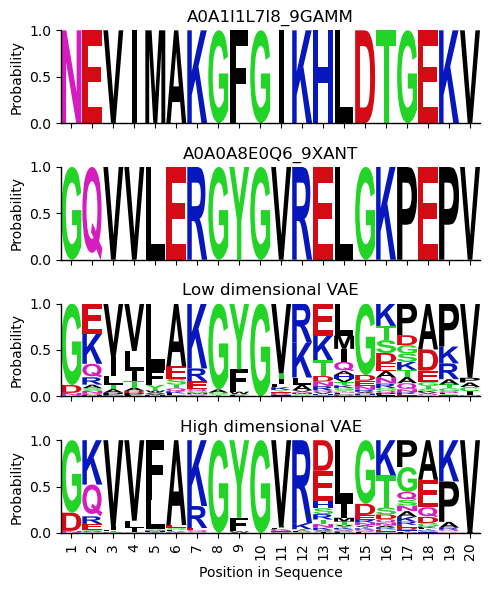

In [31]:
anc = "A35368"
# construct the distribution arrays for these sequences
child1 = "NEVIMAKGFGIKHLDTGEKV"
child2 = "GQVVLERGYGVRELGKPEPV"
child1_seq = np.zeros((len(child1), 21))
child2_seq = np.zeros((len(child1), 21))
for i in range(len(child1)):
    idx_1 = AA2IDX[child1[i]]
    idx_2 = AA2IDX[child2[i]]
    child1_seq[i, idx_1] = 1.
    child2_seq[i, idx_2] = 1.

idx_seq = anc_id.get_loc(anc)
dists = [
    #(consensus_probs[idx_seq], "Profile"),
    (child1_seq, "A0A1I1L7I8_9GAMM"),
    (child2_seq, "A0A0A8E0Q6_9XANT"),
    #(recon_iq_probs[idx_seq], "IQTree"),
    #(get_ardca_dist(anc), "ArDCA"),
    (recon_vae_ld_probs[idx_seq], "Low dimensional VAE"),
    (recon_vae_hd_probs[idx_seq], "High dimensional VAE"),
]

interval = (1, 21)
fig, axes = plt.subplots(len(dists), 1, figsize=(5, 6), sharex=True)
for ax, (dist, title) in zip(axes, dists):
    plot_logo(dist, interval=interval, ax=ax)
    ax.set_title(title)

# Only show x-label on the bottom plot
for ax in axes[:-1]:
    ax.set_xlabel("")
    ax.set_xticklabels([])
axes[-1].set_xlabel('Position in Sequence')
axes[-1].set_xticks(range(interval[1]-interval[0]))
axes[-1].set_xticklabels(range(interval[0], interval[1]), rotation=90)

# Display plot
plt.tight_layout()
plt.savefig(f"figures/PF00144_og/{anc}_logo.pdf")
plt.show()



Root

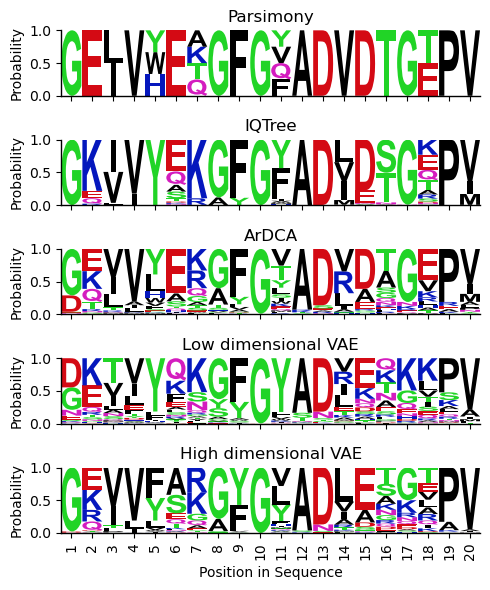

In [32]:
anc = "Root"
root_parsimony_seq = np.zeros((interval[1]-interval[0], 21))
for idx_row, idx_seq in enumerate(range(interval[0], interval[1])):
    possible_states = root_profile[idx_seq]
    n_possible_states = len(possible_states)
    for char in possible_states:
        aa_idx = AA2IDX[char]
        root_parsimony_seq[idx_row, aa_idx] = 1. / n_possible_states 

idx_seq = anc_id.get_loc(anc)
dists = [
    #(consensus_probs[idx], "Profile"),
    (root_parsimony_seq, "Parsimony"),
    (recon_iq_probs[anc_id.get_loc("A27193")], "IQTree"), #IQTree doesn't reconstruct for root but A27193 is right next to root
    (get_ardca_dist(anc), "ArDCA"),
    (recon_vae_ld_probs[idx_seq], "Low dimensional VAE"),
    (recon_vae_hd_probs[idx_seq], "High dimensional VAE"),
]

fig, axes = plt.subplots(len(dists), 1, figsize=(5,6), sharex=True)
for ax, (dist, title) in zip(axes, dists):
    plot_logo(dist, interval=interval, ax=ax)
    ax.set_title(title)

# Only show x-label on the bottom plot
for ax in axes[:-1]:
    ax.set_xlabel("")
    ax.set_xticklabels([])
axes[-1].set_xlabel('Position in Sequence')
axes[-1].set_xticks(range(interval[1]-interval[0]))
axes[-1].set_xticklabels(range(interval[0], interval[1]), rotation=90)


# Display plot
plt.tight_layout()
plt.savefig(f"figures/PF00144_og/{anc}_logo.pdf")
plt.show()